# LLM Energy Analysis Dashboard

Comprehensive analysis of energy consumption patterns across different LLM models.


In [69]:
# Import libraries for data analysis and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sns.set_style("whitegrid")
sns.set_palette("Blues")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)


In [70]:
df = pd.read_json('data/energy.jsonl', lines=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['prompt_length'] = df['prompt'].str.len()
df['response_length'] = df['response'].str.len()
df['energy_per_token'] = df['energy_consumed_wh'] / df['total_tokens']
df['energy_per_char'] = df['energy_consumed_wh'] / df['prompt_length']
df['model_short'] = df['model'].str.extract(r'([a-z-]+)')[0]

dataset_info = pd.DataFrame({
    'Metric': ['Total Records', 'Models', 'Date Range'],
    'Value': [f"{len(df):,}", f"{df['model'].nunique()}", f"{df['timestamp'].min()} to {df['timestamp'].max()}"]
})
dataset_info


,Metric,Value
0,Total Records,"1,899"
1,Models,3
2,Date Range,2025-10-19 20:18:09 to 2025-10-20 08:13:23


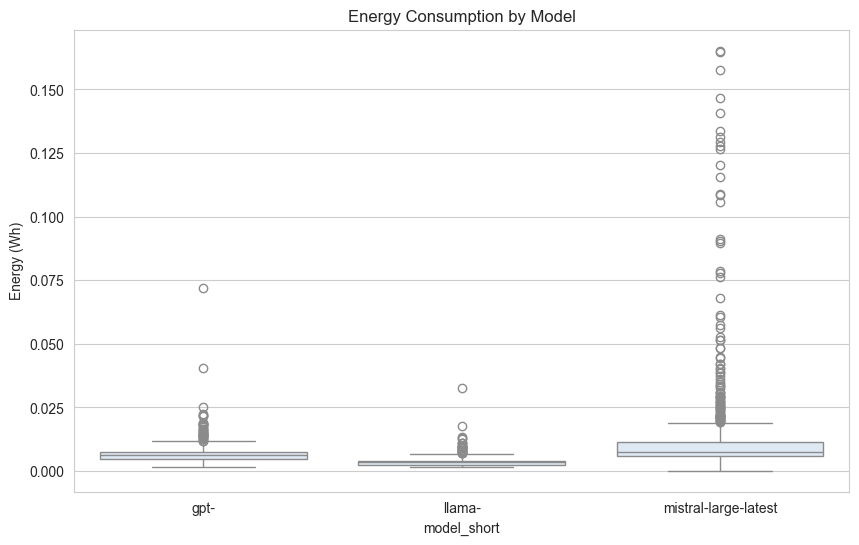

,mean,std,min,max
model_short,,,,
gpt-,0.0066,0.0043,0.0014,0.0718
llama-,0.0035,0.0021,0.0014,0.0325
mistral-large-latest,0.0140,0.0220,0.0001,0.1653


In [71]:
def remove_outliers(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

df_clean = remove_outliers(df, 'energy_consumed_wh')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='model_short', y='energy_consumed_wh')
plt.title('Energy Consumption by Model')
plt.ylabel('Energy (Wh)')
plt.show()

energy_summary = df_clean.groupby('model_short')['energy_consumed_wh'].agg(['mean', 'std', 'min', 'max']).round(4)
energy_summary


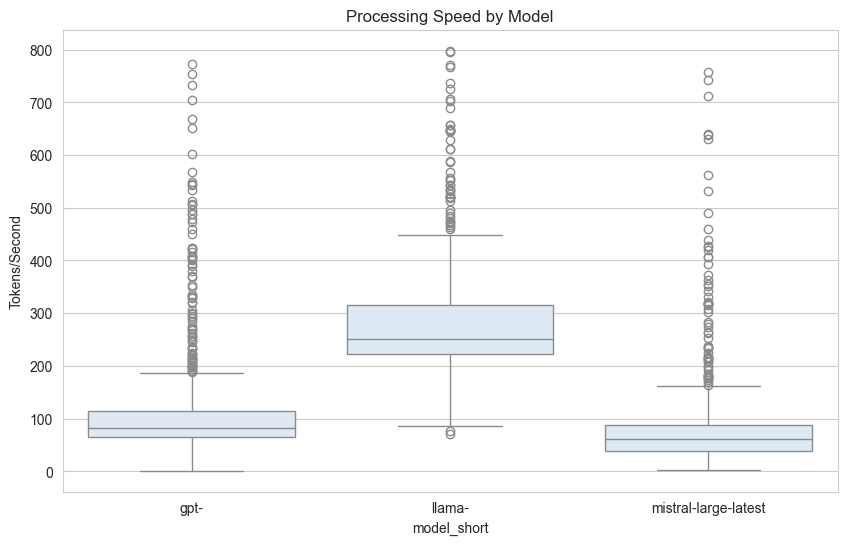

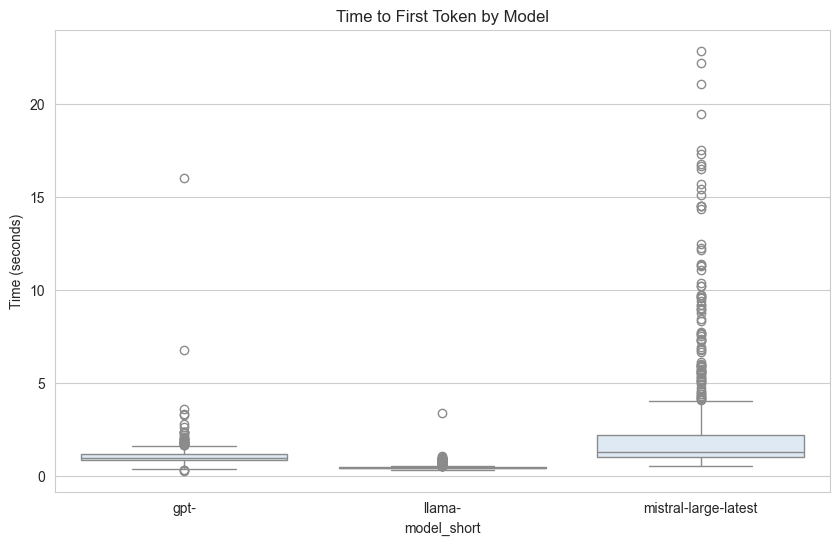

,tokens_per_second,time_to_first_token,duration
model_short,,,
gpt-,128.332,1.511,1.511
llama-,340.886,0.439,0.440
mistral-large-latest,86.432,2.577,2.578


In [72]:
df_clean_speed = remove_outliers(df, 'tokens_per_second')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean_speed, x='model_short', y='tokens_per_second')
plt.title('Processing Speed by Model')
plt.ylabel('Tokens/Second')
plt.show()

df_clean_time = remove_outliers(df, 'time_to_first_token')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean_time, x='model_short', y='time_to_first_token')
plt.title('Time to First Token by Model')
plt.ylabel('Time (seconds)')
plt.show()

performance_summary = df.groupby('model_short').agg({
    'tokens_per_second': 'mean',
    'time_to_first_token': 'mean',
    'duration': 'mean'
}).round(3)
performance_summary


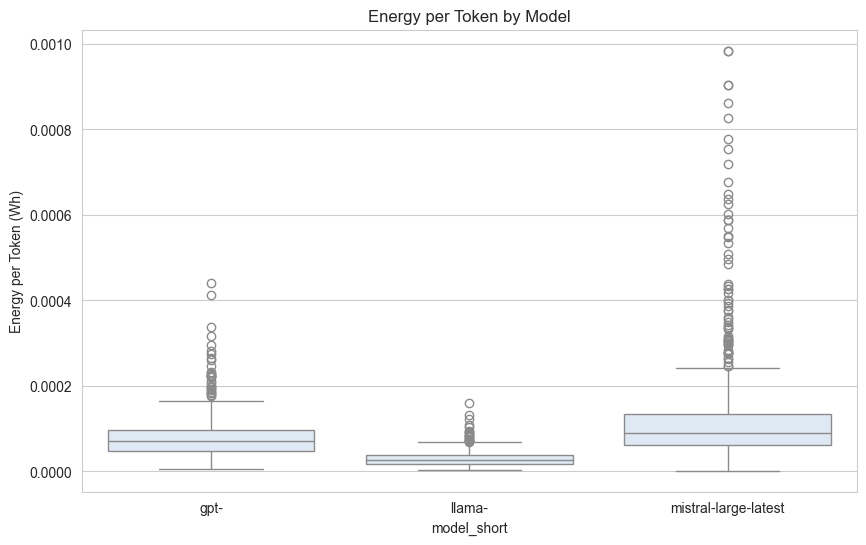

,energy_consumed_wh,tokens_per_second,energy_per_token
model_short,,,
gpt-,0.0103,128.3316,0.0001
llama-,0.0035,340.8859,0.0000
mistral-large-latest,0.0165,86.4315,0.0002


In [73]:
df_clean_eff = remove_outliers(df, 'energy_per_token')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean_eff, x='model_short', y='energy_per_token')
plt.title('Energy per Token by Model')
plt.ylabel('Energy per Token (Wh)')
plt.show()

efficiency_data = df.groupby('model_short').agg({
    'energy_consumed_wh': 'mean',
    'tokens_per_second': 'mean',
    'energy_per_token': 'mean'
}).round(4)
efficiency_data


C:\Users\evanm\AppData\Local\Temp\ipykernel_23348\44544135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_hour['hour'] = df_clean_hour['timestamp'].dt.hour


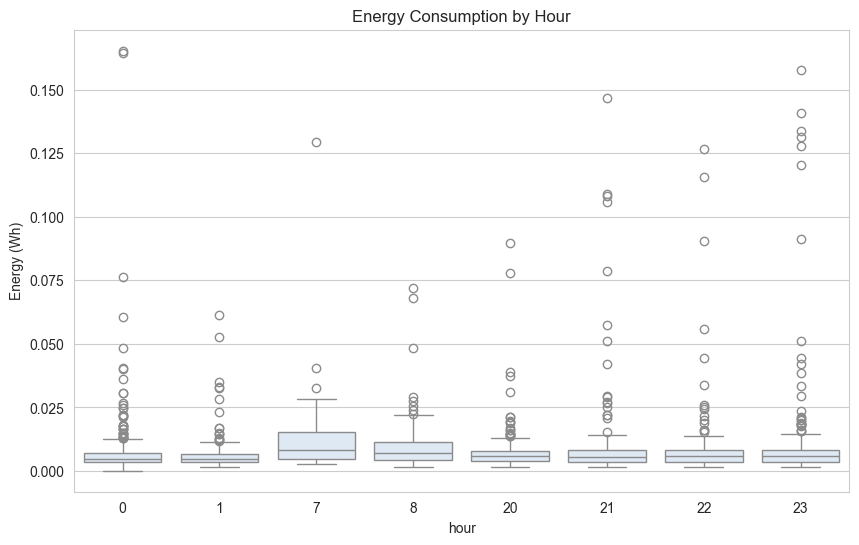

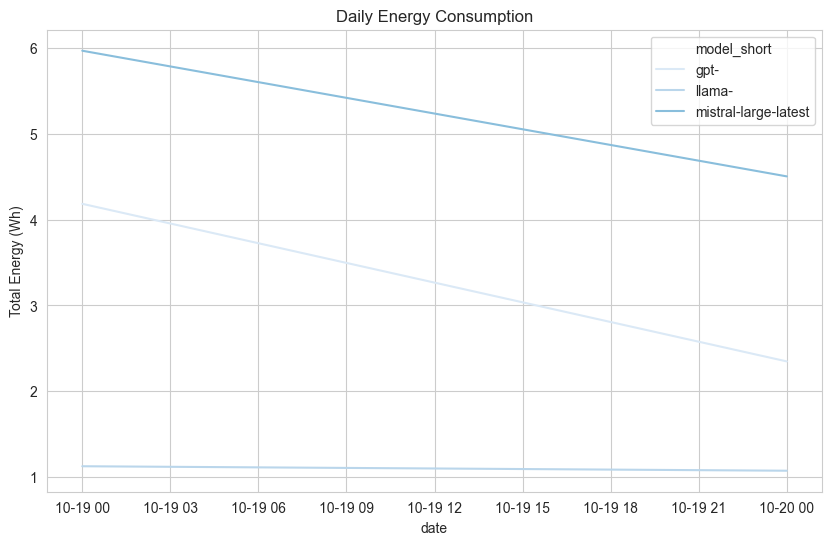

In [74]:
df['hour'] = df['timestamp'].dt.hour
df_clean_hour = remove_outliers(df, 'energy_consumed_wh')
df_clean_hour['hour'] = df_clean_hour['timestamp'].dt.hour
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean_hour, x='hour', y='energy_consumed_wh')
plt.title('Energy Consumption by Hour')
plt.ylabel('Energy (Wh)')
plt.show()

df['date'] = df['timestamp'].dt.date
daily_energy = df.groupby(['date', 'model_short'])['energy_consumed_wh'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_energy, x='date', y='energy_consumed_wh', hue='model_short')
plt.title('Daily Energy Consumption')
plt.ylabel('Total Energy (Wh)')
plt.show()


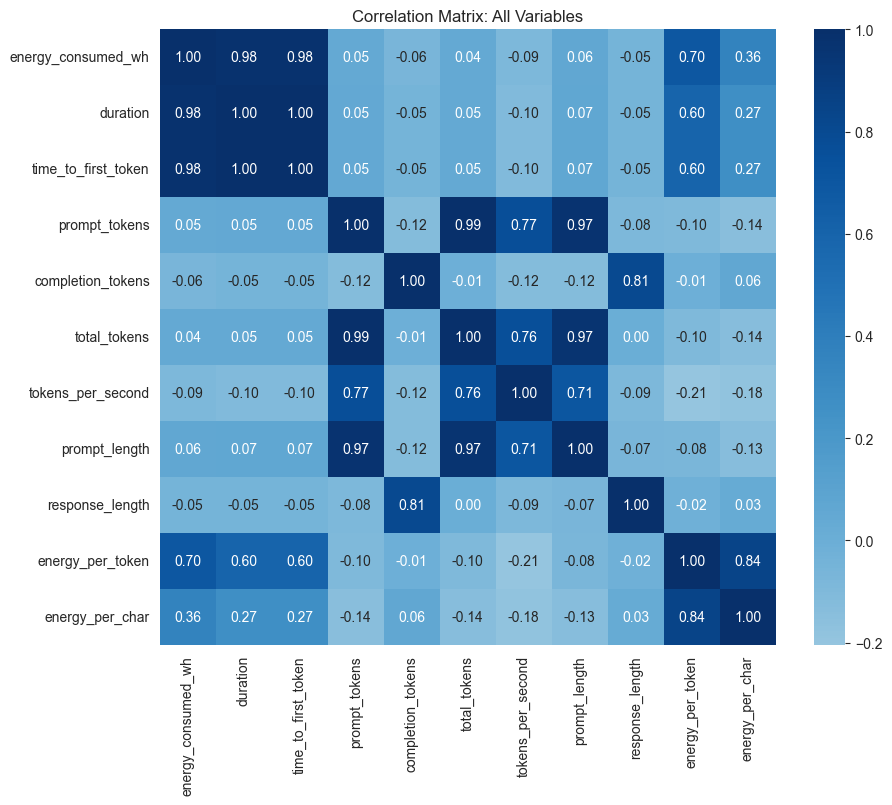

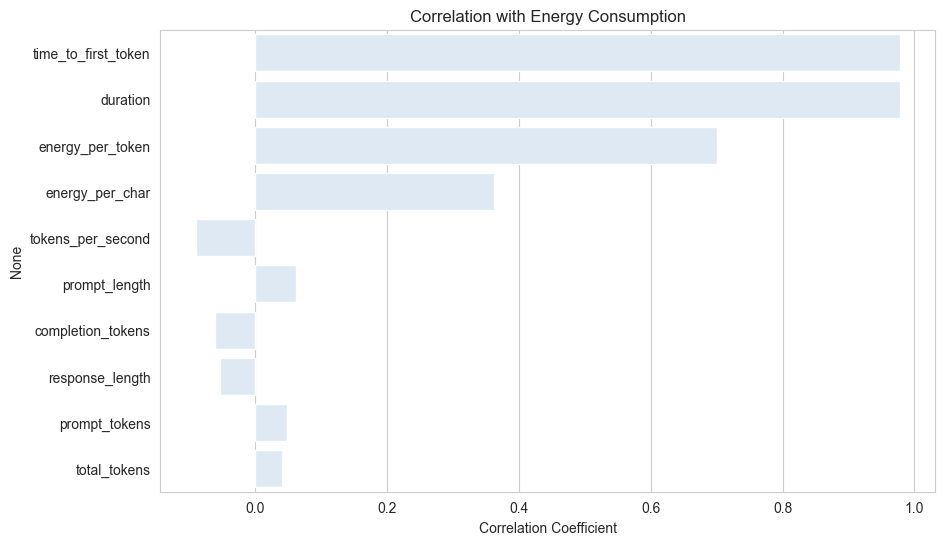

In [75]:
insights = pd.DataFrame({
    'Metric': ['Most Energy-Efficient', 'Fastest Model', 'Most Consistent'],
    'Model': [
        df.groupby('model_short')['energy_per_token'].mean().idxmin(),
        df.groupby('model_short')['tokens_per_second'].mean().idxmax(),
        df.groupby('model_short')['energy_consumed_wh'].std().idxmin()
    ]
})
insights

numeric_cols = ['energy_consumed_wh', 'duration', 'time_to_first_token', 
                'prompt_tokens', 'completion_tokens', 'total_tokens', 
                'tokens_per_second', 'prompt_length', 'response_length',
                'energy_per_token', 'energy_per_char']

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix: All Variables')
plt.show()

energy_corr = correlation_matrix['energy_consumed_wh'].drop('energy_consumed_wh').sort_values(key=abs, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=energy_corr.values, y=energy_corr.index)
plt.title('Correlation with Energy Consumption')
plt.xlabel('Correlation Coefficient')
plt.show()


In [76]:
summary_stats = df.groupby('model_short').agg({
    'energy_consumed_wh': ['mean', 'std'],
    'tokens_per_second': 'mean',
    'energy_per_token': 'mean',
    'duration': 'mean'
}).round(4)

summary_stats.columns = ['Energy_Mean', 'Energy_Std', 'Speed', 'Efficiency', 'Duration']
summary_stats


,Energy_Mean,Energy_Std,Speed,Efficiency,Duration
model_short,,,,,
gpt-,0.0103,0.0844,128.3316,0.0001,1.5109
llama-,0.0035,0.0021,340.8859,0.0000,0.4401
mistral-large-latest,0.0165,0.0332,86.4315,0.0002,2.5784
